<a href="https://colab.research.google.com/github/israt-tabassum/AirQuality_Univariate/blob/main/GatedTabTransformer_Tromso_PM2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Required Libraries
!pip install tsai
!pip install pandas scikit-learn numpy matplotlib

from tsai.all import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from google.colab import drive
import torch.nn as nn
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.learner import Callback

# Define a custom GradientClipping callback
class GradientClipping(Callback):
    def __init__(self, clip_value):
        self.clip_value = clip_value

    def before_step(self):
        for p in self.learn.model.parameters():
            if p.grad is not None:
                p.grad.data.clamp_(-self.clip_value, self.clip_value)

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Load the data
df = pd.read_csv('/content/drive/MyDrive/AirQuality/tromso_PM2.5_hourly_e1_csv/tromso_PM2.5_hourly_e1.csv', parse_dates=['Start', 'End'])

# Filter and preprocess data
df = df[['Start', 'Value']].sort_values(by='Start')
scaler = MinMaxScaler()
df['Value'] = scaler.fit_transform(df[['Value']])

# Extract the values for modeling
values = df['Value'].values

# Create time series dataset using `tsai`'s SlidingWindow
sequence_length = 50  # Sequence length
forecast_steps = 12   # Forecast steps
X, y = SlidingWindow(window_len=sequence_length, horizon=forecast_steps)(values)


if X.ndim == 2:
    X = X[..., None]

# 80:10:10 Split for Training, Validation, and Testing
train_size = int(0.8 * len(X))
valid_size = int(0.1 * len(X))
test_size = len(X) - train_size - valid_size

train_idx = range(train_size)  # First 80% for training
valid_idx = range(train_size, train_size + valid_size)  # Next 10% for validation
test_idx = range(train_size + valid_size, len(X))  # Last 10% for testing

splits = (list(train_idx), list(valid_idx))
test_split = list(test_idx)

# Convert to DataLoaders for tsai
tfms = [None, TSForecasting()]

# Create DataLoader with batch size 16
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=16)  # Batch size 16

 #Define a simple custom time-series model to avoid issues with TabTransformer
class SimpleForecastingModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):  # Hidden dim
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, (hidden, _) = self.lstm(x)
        # Pass the last hidden state through a fully connected layer
        output = self.fc(hidden[-1])
        return output


model = SimpleForecastingModel(input_dim=sequence_length, output_dim=forecast_steps, hidden_dim=32)

# Create a Learner with early stopping and gradient clipping
learn = Learner(
    dls, model,
    loss_func=MSELossFlat(),
    metrics=mae,
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', patience=3),
        GradientClipping(clip_value=0.1)
    ]
)

# Train the model
learn.fit_one_cycle(10, lr_max=1e-3)

# Evaluate on validation set
valid_mae = learn.validate()[1]
print(f"Validation MAE: {valid_mae:.4f}")

# Evaluate on test set
test_dls = get_ts_dls(X, y, splits=(test_split, []), tfms=tfms, bs=16)
test_preds, test_targs = learn.get_preds(dl=test_dls.train)
test_y_pred = test_preds.numpy()
test_y_true = test_targs.numpy()
test_y_pred = scaler.inverse_transform(test_y_pred)
test_y_true = scaler.inverse_transform(test_y_true.reshape(-1, forecast_steps))
test_rmse = sqrt(mean_squared_error(test_y_true.flatten(), test_y_pred.flatten()))
print(f"Test RMSE: {test_rmse:.4f}")



Mounted at /content/drive


epoch,train_loss,valid_loss,mae,time
0,0.000385,0.000001,0.000820,00:04
1,0.000268,0.000000,0.000414,00:05
2,0.000052,0.000000,0.000281,00:06
3,0.000458,0.000014,0.002198,00:04
4,0.000511,0.000002,0.001285,00:04
5,0.000075,0.000001,0.000410,00:05


No improvement since epoch 2: early stopping


Validation MAE: 0.0004


Test RMSE: 110658.5494


Predicted next 12 values: [ -4689055.   -12522423.    -5537791.5   -8620284.     7955986.
  -1489297.4    -388049.53   -701732.56  11151329.     5756998.5
   -655128.56  12225139.  ]


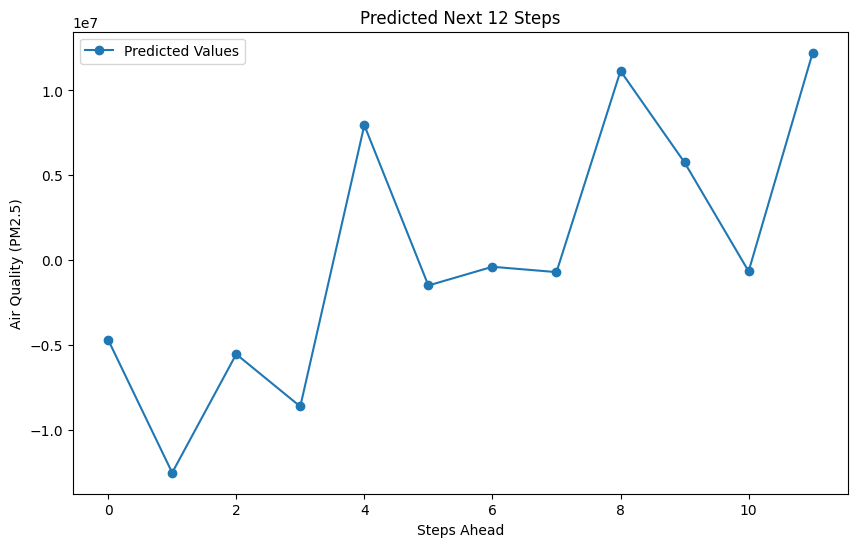

In [12]:

last_seq = values[-sequence_length:].reshape(1, sequence_length, 1)  # Shape: (1, sequence_length, 1)


last_seq = np.repeat(last_seq, sequence_length, axis=2)


assert last_seq.shape == (1, sequence_length, sequence_length), f"Expected shape (1, {sequence_length}, {sequence_length}), but got {last_seq.shape}"

model.eval()

# Move the model to the same device as the input data
model.to(learn.dls.device)

with torch.no_grad():
    # Convert the input sequence to a tensor and move it to the device
    input_tensor = torch.tensor(last_seq).float().to(learn.dls.device)

    # Get predictions
    preds = model(input_tensor).cpu().numpy()  # Move predictions back to CPU

# Inverse transform the predictions to the original scale
preds = scaler.inverse_transform(preds)

# Print predictions
print(f"Predicted next {forecast_steps} values: {preds.flatten()}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(preds.flatten(), label='Predicted Values', marker='o')
plt.title(f"Predicted Next {forecast_steps} Steps")
plt.xlabel("Steps Ahead")
plt.ylabel("Air Quality (PM2.5)")
plt.legend()
plt.show()


In [13]:
# Define a simple custom time-series model to avoid issues with TabTransformer
class SimpleForecastingModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=32):  # Hidden dim
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)  # input_dim should be 1
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, (hidden, _) = self.lstm(x)
        # Pass the last hidden state through a fully connected layer
        output = self.fc(hidden[-1])
        return output

# Initialize the model with input_dim=1
model = SimpleForecastingModel(input_dim=1, output_dim=forecast_steps, hidden_dim=32)

Predicted next 12 values: [  6709266.5  12463482.  -34265136.  -17453868.   -3783662.2   6476269.
  30758912.   28384654.  -10078351.   30239980.   17801020.  -14916720. ]


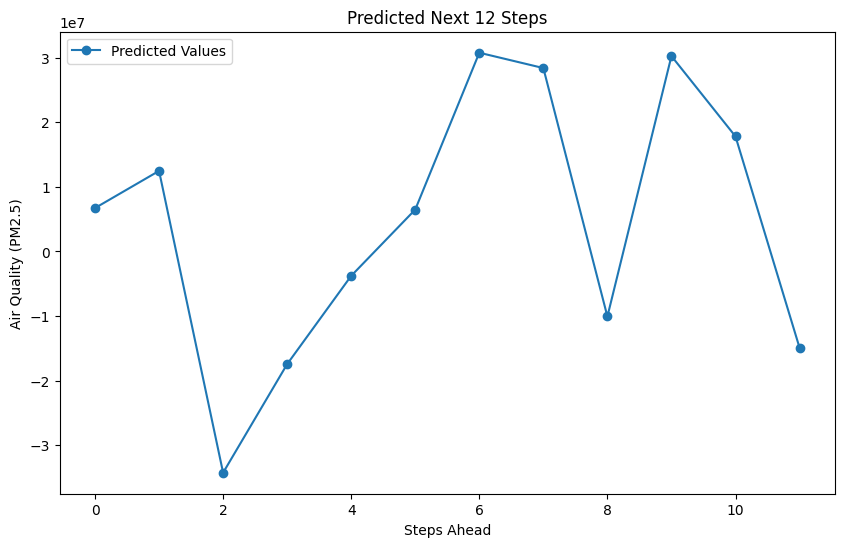

In [14]:
# Predict future steps
last_seq = values[-sequence_length:].reshape(1, sequence_length, 1)  # Last sequence as input

# Ensure the shape is (1, sequence_length, 1)
assert last_seq.shape == (1, sequence_length, 1), f"Expected shape (1, {sequence_length}, 1), but got {last_seq.shape}"

model.eval()

model.to(learn.dls.device)

with torch.no_grad():
    # Move the input tensor to the same device as the model
    preds = model(torch.tensor(last_seq).float().to(learn.dls.device)).cpu().numpy()
preds = scaler.inverse_transform(preds)  # Inverse transform to original scale

# Print predictions
print(f"Predicted next {forecast_steps} values: {preds.flatten()}")


# Visualize predictions
plt.figure(figsize=(10, 6))
plt.plot(preds.flatten(), label='Predicted Values', marker='o')
plt.title(f"Predicted Next {forecast_steps} Steps")
plt.xlabel("Steps Ahead")
plt.ylabel("Air Quality (PM2.5)")
plt.legend()
plt.show()